## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [3]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [4]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['n_age'] = 2020-df['birth_year']

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df.disease.fillna(0,inplace=True)

In [12]:
df.disease.replace(True, 1,inplace=True)

In [13]:
df.disease.value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [14]:
df['global_num'].fillna((df['global_num'].mean()), inplace=True)

In [15]:
df['birth_year'].fillna((df['birth_year'].mean()), inplace=True)

In [16]:
df['infection_order'].fillna((df['infection_order'].mean()), inplace=True)

In [17]:
df['infected_by'].fillna((df['infected_by'].mean()), inplace=True)

In [18]:
df['contact_number'].fillna((df['contact_number'].mean()), inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

deceased_date

In [19]:
# Check deceased_date with state
df[~df['deceased_date'].isnull()][['deceased_date','state']]

,deceased_date,state
109,2020-03-19,released
187,2020-03-19,released
388,2020-02-23,deceased
427,2020-02-26,deceased
428,2020-03-02,deceased
429,2020-03-04,deceased
430,2020-03-01,deceased
431,2020-03-02,deceased
432,2020-02-27,deceased
433,2020-03-05,deceased


In [20]:
# deceased_date, lots of people is still alive, so we fill na with "Alive"
df['deceased_date'].fillna('Alive', inplace=True)

symptom_onset_date

In [21]:
# symptom_onset_date, null value might indicate the date for onset is unknown
df['symptom_onset_date'].fillna('Unknown', inplace=True)

released_date

In [22]:
# released_date. Since the dataset is as of March, many people is still not under treatment. 
# Null value in released_date means this patient is not released yet
df['released_date'].fillna('Not yet released', inplace=True)

infection_case

In [23]:
# infection_case indicate the reason and location of infection. 
# Null value means unknow source of infection
df['infection_case'].fillna('Unknown', inplace=True)

n_age

In [24]:
# n_age, due to missing values in birth_year, we got missing value here. re-calculate the n_age based on birth_year
df['n_age'] = 2020-df['birth_year']

age

In [25]:
# age, we can get age by using n_age columns
df['age'].value_counts()

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [26]:
age_null = df[df['age'].isna()].index.tolist()

In [27]:
# age, we can get age by using n_age columns
df['age'].fillna((df['n_age']//10*10).astype(int).astype(str) + 's', inplace=True)

In [28]:
# check if filled in correctly
df.iloc[age_null][['age','n_age']].sample(10)

,age,n_age
1847,40s,45.011338
1863,40s,45.011338
847,50s,58.000000
1854,40s,45.011338
824,70s,71.000000
798,60s,64.000000
825,60s,62.000000
790,50s,57.000000
829,60s,61.000000
1739,40s,45.011338


In [29]:
df['age'].value_counts()

20s     482
40s     470
50s     409
30s     271
60s     248
70s     124
80s      85
10s      79
0s       32
90s      17
100s      1
Name: age, dtype: int64

sex

In [30]:
#sex, use forward fill method to fill the missing values
df['sex'].fillna(method='ffill', inplace=True)

In [31]:
df['sex'].value_counts()

female    1173
male      1045
Name: sex, dtype: int64

confirmed_date

In [32]:
# confirmed_date,compare the confirmed date with symptom onset date.
df[df['confirmed_date'].isna()]['symptom_onset_date'].value_counts()
# symptom onset date is all Unknown when the confirmaed date is missing

Unknown    141
Name: symptom_onset_date, dtype: int64

In [33]:
# The confirmed_date in the dataset is ordered by date, so we use forward fill method to fill the missing values
df['confirmed_date'].fillna(method='ffill', inplace=True)

city

In [34]:
df['city'].fillna('Unknown', inplace=True)

state

In [35]:
df['state'].value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [36]:
# All patient with missing value in state is not yet released from the hospital. So we will label these patients with 'isolated'
df[df['state'].isnull()]['released_date'].value_counts()

Not yet released    88
Name: released_date, dtype: int64

In [37]:
df['state'].fillna('isolated', inplace=True)

In [38]:
df['state'].value_counts()

isolated    1879
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [39]:
# No more missing values
df.notnull().all().all()

True

In [40]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,Alive,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,Unknown,2020-01-30,2020-03-02,Alive,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,Unknown,2020-01-30,2020-02-19,Alive,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,Alive,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,Unknown,2020-01-31,2020-02-24,Alive,released,28.0


Remove date columns from the data.


In [41]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [42]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                135
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [43]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
dtype: float64


Review the range of values per column.

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [45]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [46]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,135
5,infection_case,17
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

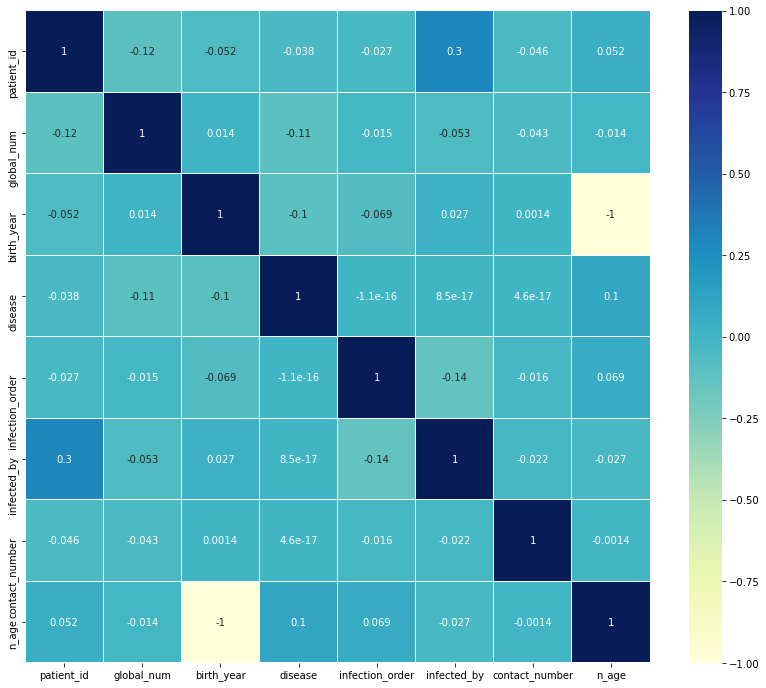

In [47]:
# Make a heatmap of the data 
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

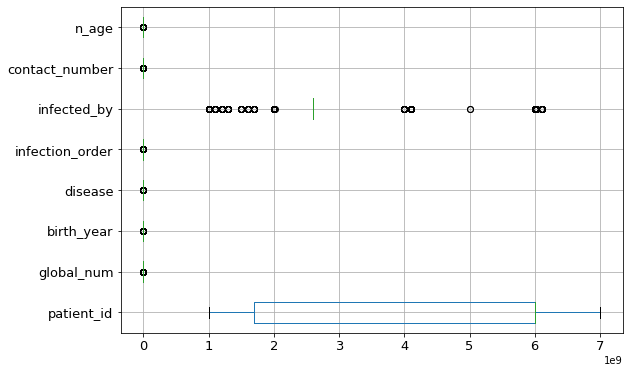

In [48]:
all_box = df.boxplot(vert=False,fontsize=13,figsize=(9,6))

**<font color='teal'> Create dummy features for object type features. </font>**

In [49]:
X=df.drop(['state'], axis=1)
y = df['state']

In [50]:
X=pd.get_dummies(X)

In [51]:
X.shape

(2218, 194)

In [52]:
y.shape

(2218,)

### Scale data to prep for model creation

In [53]:
#scale data
from sklearn import preprocessing
import numpy as np

scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 

### Split the data into test and train subsamples

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.8, random_state=1)

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier

In [78]:
import time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
#lr_auc = roc_auc_score(y_test, lr_probs)
ac = accuracy_score(y_test, y_pred)
#lo = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
#print('Training Data Set 1 RandomForest: ROC AUC=%.3f' % (lr_auc))
print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
#print('Training Data Set 1 Random Forest: Log loss=%.3f' % (lo))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

Training Data Set 1 Random Forest: Accuracy=0.848
Training Data Set 1 Random Forest: f1-score=0.810


In [71]:
#y_pred_prob

In [72]:
#y_pred_prob[:,1]

In [73]:
#y_pred

### Create Confusion Matrix Plots

In [79]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  13   10    0]
 [   0 1463   40]
 [   0  220   29]]
Normalized confusion matrix
[[0.57 0.43 0.  ]
 [0.   0.97 0.03]
 [0.   0.88 0.12]]


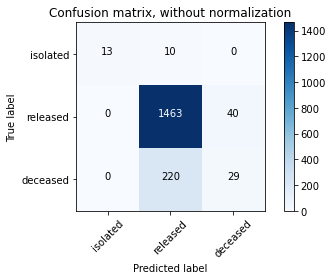

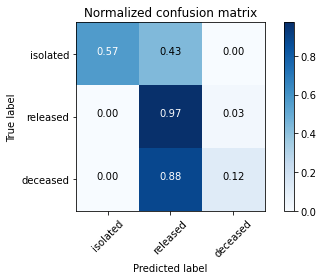

In [80]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances

30


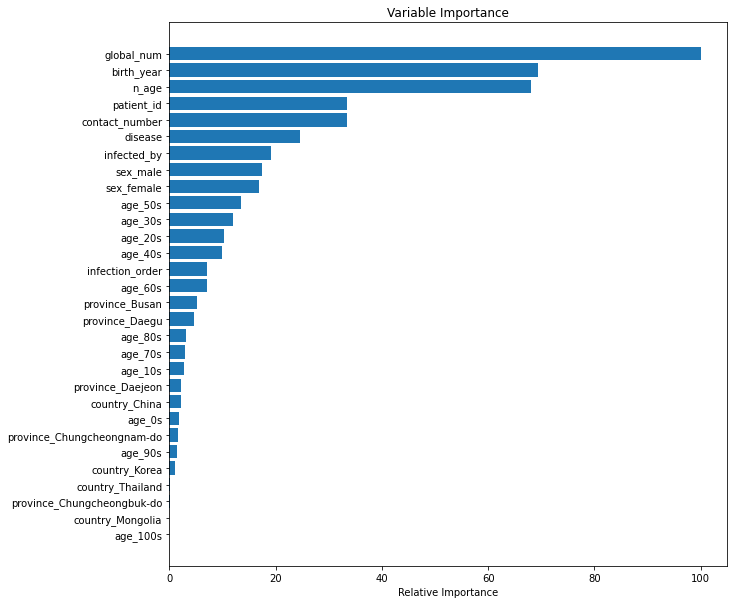

In [58]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model does not. In this case study, you saw the performance ability even with only a few features and almost all of them were highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features within a large dataset. Random forest should be your first choice you turn to when building a decision tree, especially when working with multiclass classifications.

In [81]:
# Use GridSearchCV to tune the hyperparameter
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param = {'n_estimators':[50,100,300],
        'max_depth':[5,10,30,60,90,None]}
gs = GridSearchCV(rf,param,cv=5,n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)

In [82]:
# max_depth = 10, param_n_estimators = 100 gives the maximum test score
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.164958,0.010376,0.009973,0.001262,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.865169,0.853933,0.831461,0.875000,0.863636,0.857840,0.014785,1
0,0.162766,0.006224,0.010572,0.002647,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.865169,0.853933,0.842697,0.863636,0.863636,0.857814,0.008550,2
4,0.368016,0.034172,0.022141,0.006863,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.865169,0.865169,0.831461,0.863636,0.863636,0.857814,0.013195,2
5,1.132571,0.167961,0.071210,0.015586,10,300,"{'max_depth': 10, 'n_estimators': 300}",0.865169,0.865169,0.831461,0.863636,0.863636,0.857814,0.013195,2
1,0.322738,0.015341,0.018351,0.002863,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.865169,0.853933,0.842697,0.863636,0.852273,0.855541,0.008203,5


In [83]:
clf = RandomForestClassifier(n_estimators=100,max_depth = 10, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
#lr_auc = roc_auc_score(y_test, lr_probs)
ac = accuracy_score(y_test, y_pred)
#lo = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
#print('Training Data Set 1 RandomForest: ROC AUC=%.3f' % (lr_auc))
print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
#print('Training Data Set 1 Random Forest: Log loss=%.3f' % (lo))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

Training Data Set 1 Random Forest: Accuracy=0.859
Training Data Set 1 Random Forest: f1-score=0.801


Confusion matrix, without normalization
[[  12   11    0]
 [   0 1502    1]
 [   0  239   10]]
Normalized confusion matrix
[[5.22e-01 4.78e-01 0.00e+00]
 [0.00e+00 9.99e-01 6.65e-04]
 [0.00e+00 9.60e-01 4.02e-02]]


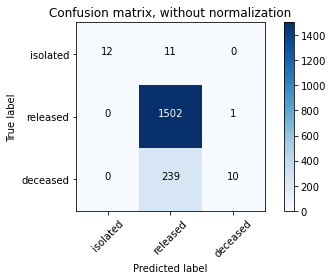

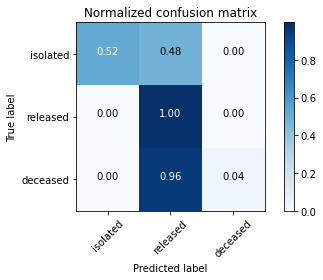

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()